# Thyroid Cancer Recurred - Classification Model

In this notebook we will create a simple binary classification model to predict recurrence of thyroid cancer.

where the model must predict a label that belongs to one of two classes

The data set used can be found in [Kaggle](https://www.kaggle.com/datasets/joebeachcapital/differentiated-thyroid-cancer-recurrence).

Per Kaggle page: "*This data set contains 13 clinicopathologic features aiming to predict recurrence of well differentiated thyroid cancer. The data set was collected in duration of 15 years and each patient was followed for at least 10 years.*"

The target feature is '***Recurred***' which indicates if a patient presented thyroid cancer again.
Here are the steps to create this model:

1. Data Preparation
2. Data Exploration
3. Train the Binary Classification Model
4. Evaluate the Model
5. Next Steps

# Data Preparation

* Handle Null Values
* Text Columns to Category Codes

### Handle Null Values

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Deactivate warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:
# Import the data
df = pd.read_csv('Thyroid_Diff.csv', low_memory=True)

df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

No nulls, we can continue as is

### Text Columns to Category Codes

In [ ]:
# Save original numerical columns
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
numerical_cols

Index(['Age'], dtype='object')

In [ ]:
# Identify categorical columns
c = (df.dtypes == 'object')
categorical_cols = list(c[c].index)
categorical_codes = []

# Keep original columns to use in the exploration
for col in df[categorical_cols]:
  col_name = col + '_cat'
  categorical_codes.append(col_name)
  df[col + '_cat'] = df[col].astype('category').cat.codes

categorical_codes

['Gender_cat',
 'Smoking_cat',
 'Hx Smoking_cat',
 'Hx Radiothreapy_cat',
 'Thyroid Function_cat',
 'Physical Examination_cat',
 'Adenopathy_cat',
 'Pathology_cat',
 'Focality_cat',
 'Risk_cat',
 'T_cat',
 'N_cat',
 'M_cat',
 'Stage_cat',
 'Response_cat',
 'Recurred_cat']

In [ ]:
df[categorical_codes].head()

,Gender_cat,Smoking_cat,Hx Smoking_cat,Hx Radiothreapy_cat,Thyroid Function_cat,Physical Examination_cat,Adenopathy_cat,Pathology_cat,Focality_cat,Risk_cat,T_cat,N_cat,M_cat,Stage_cat,Response_cat,Recurred_cat
0,0,0,0,0,2,3,3,2,1,2,0,0,0,0,2,0
1,0,0,1,0,2,1,3,2,1,2,0,0,0,0,1,0
2,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
3,0,0,0,0,2,4,3,2,1,2,0,0,0,0,1,0
4,0,0,0,0,2,1,3,2,0,2,0,0,0,0,1,0


## Data Exploration

* Basic Stats
* Data Distribution
* Relationships: Numerical & Recurred
* Relationships: Categorical & Recurred
* Select Strong Relationships Columns Only

### Basic Stats

In [ ]:
df[numerical_cols].describe()

,Age
count,383.000000
mean,40.866841
std,15.134494
min,15.000000
25%,29.000000
50%,37.000000
75%,51.000000
max,82.000000


### Data Distribution

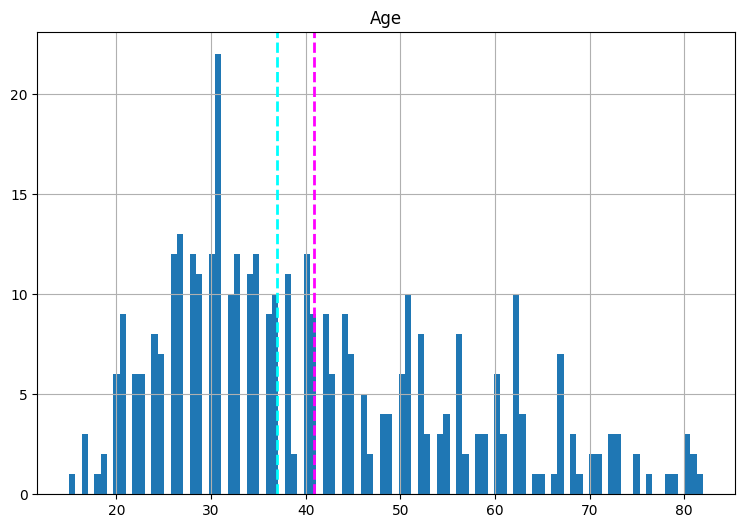

In [ ]:
# Plot a histogram for each numerical column
numerical_feature = list(numerical_cols)

for col in numerical_feature:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

### Categorical Columns

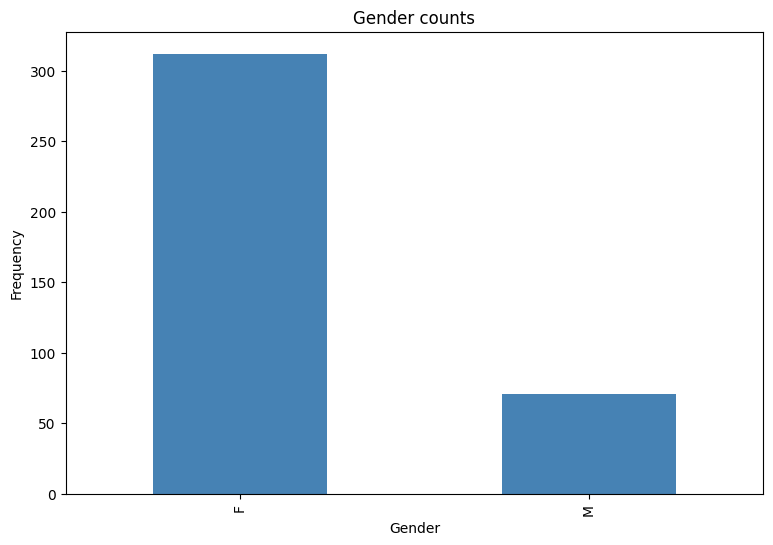

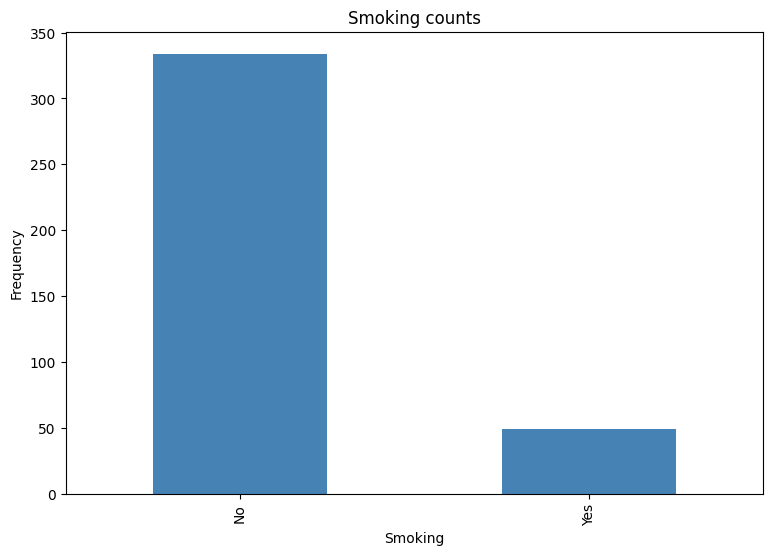

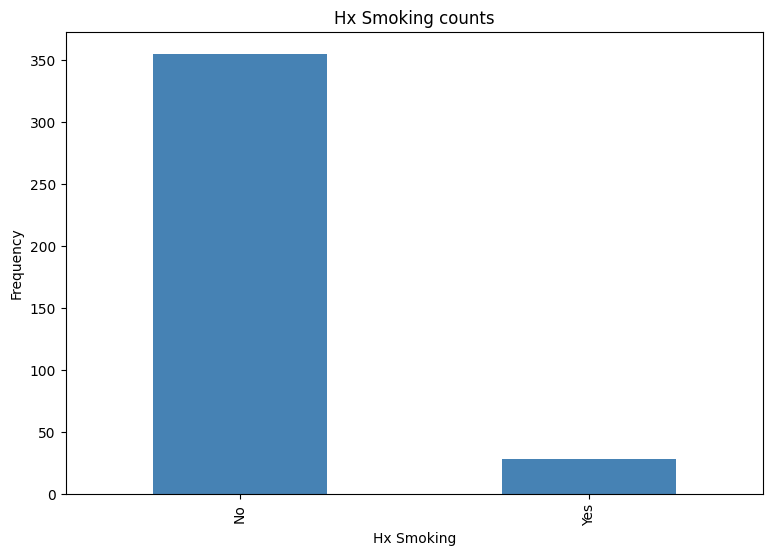

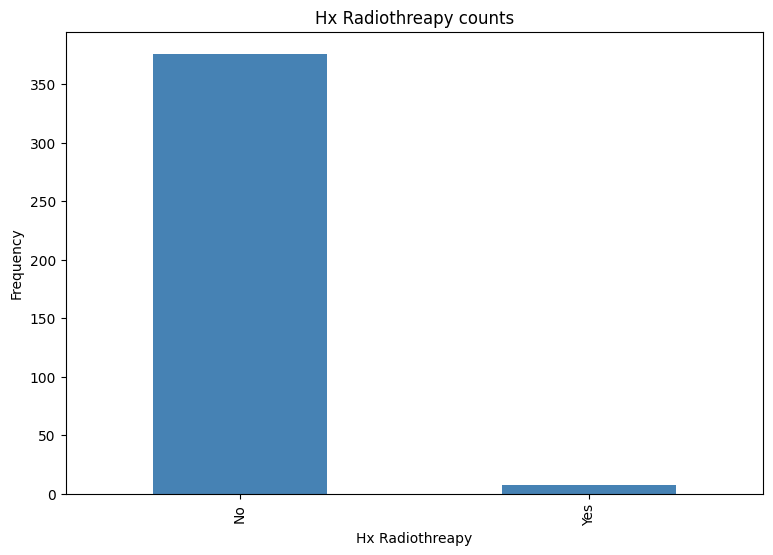

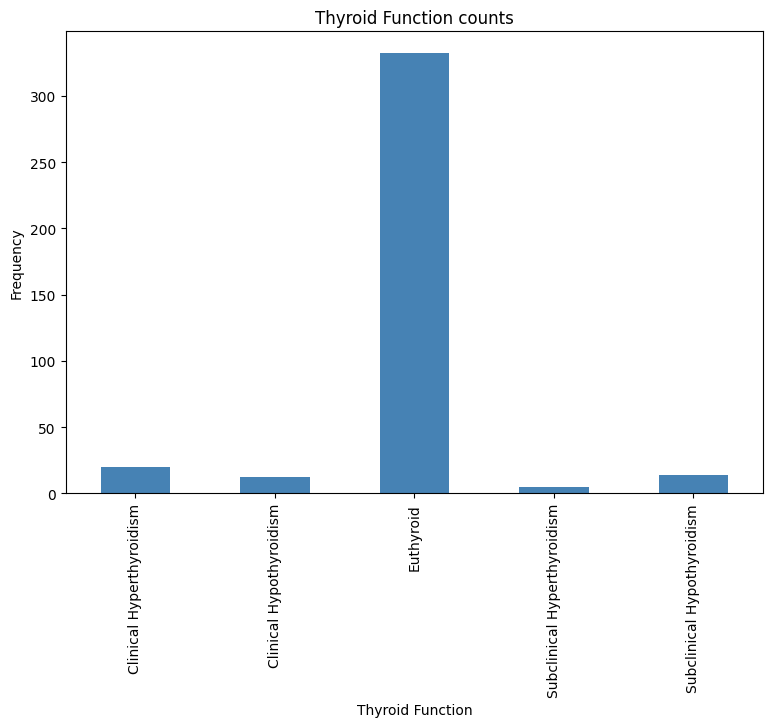

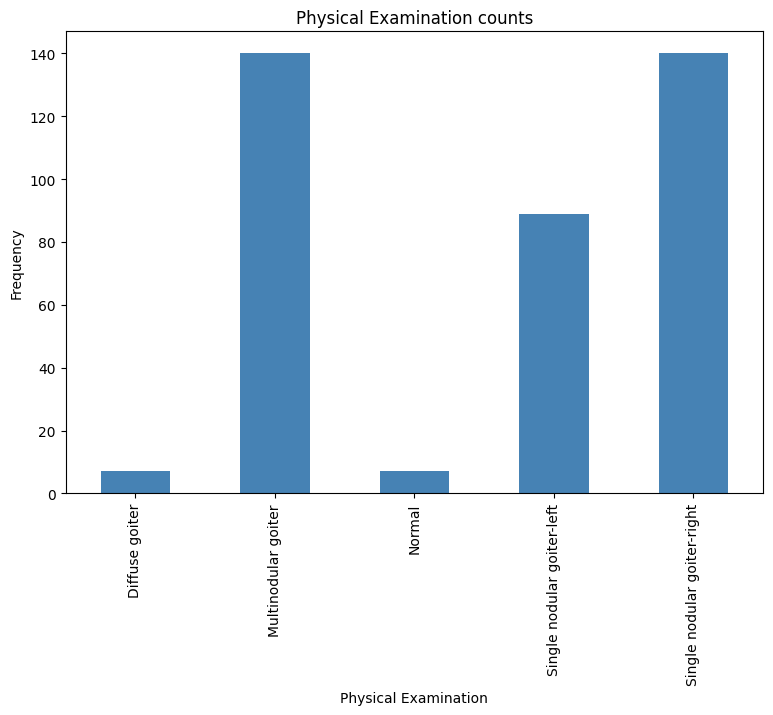

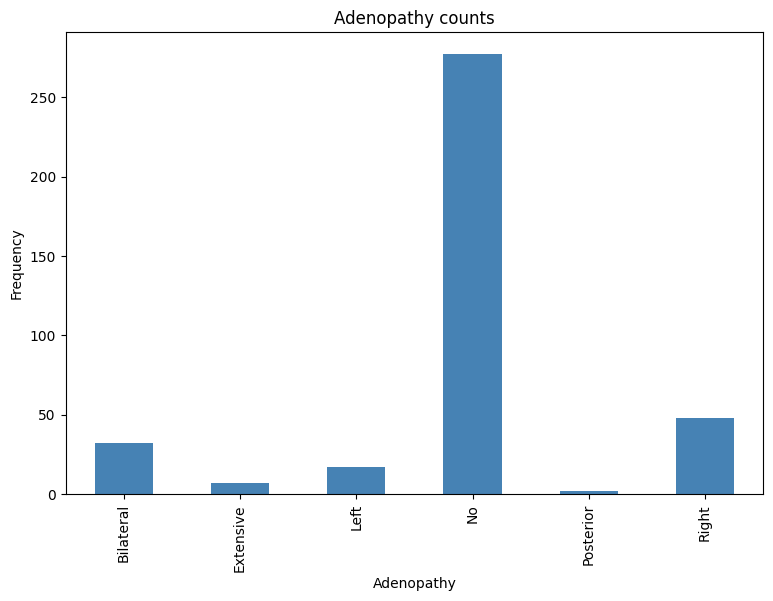

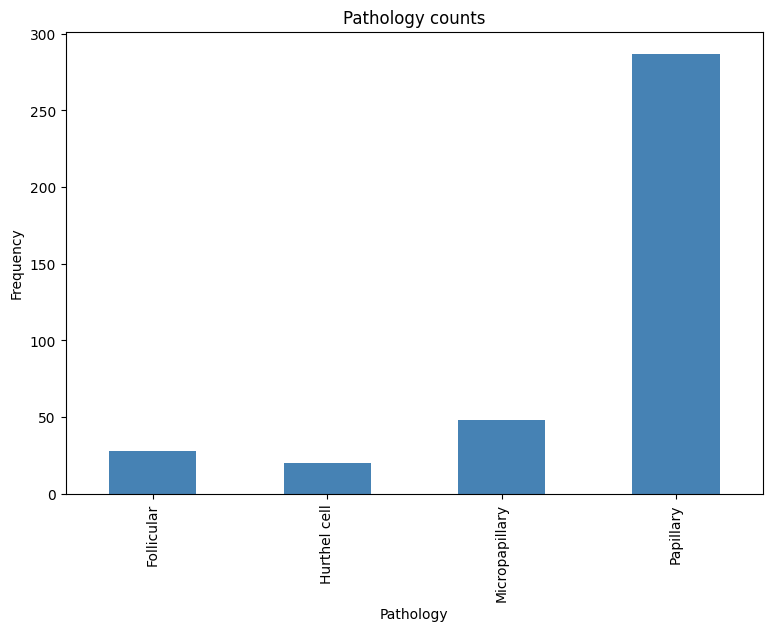

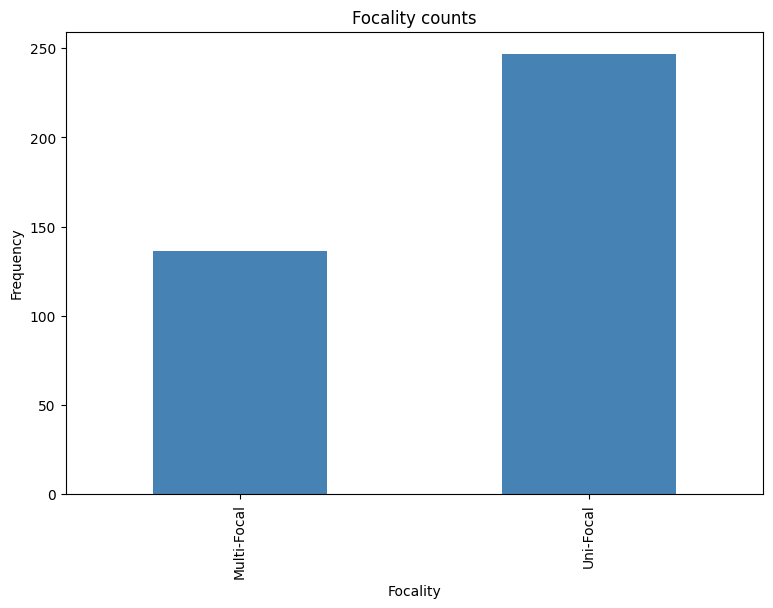

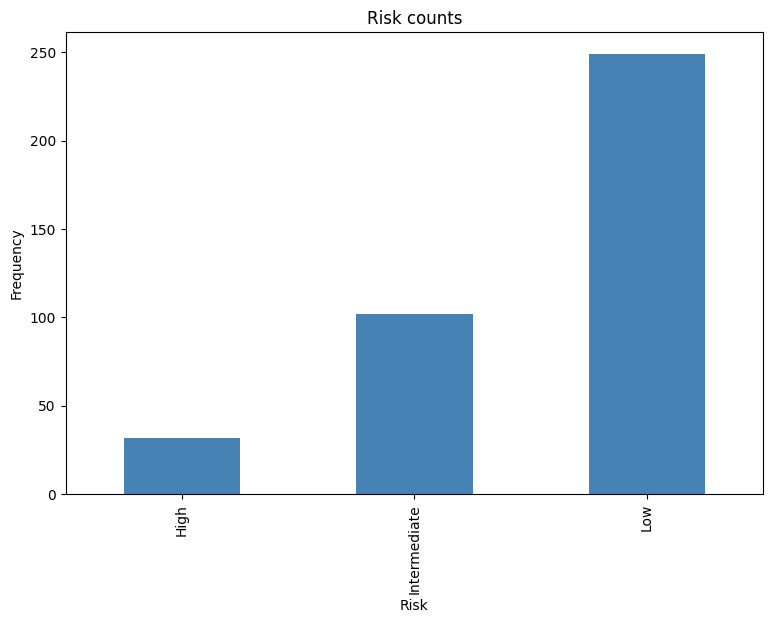

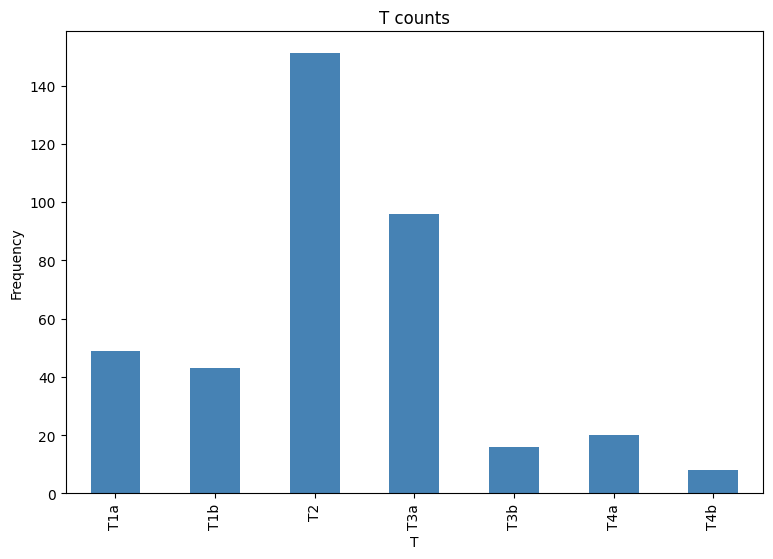

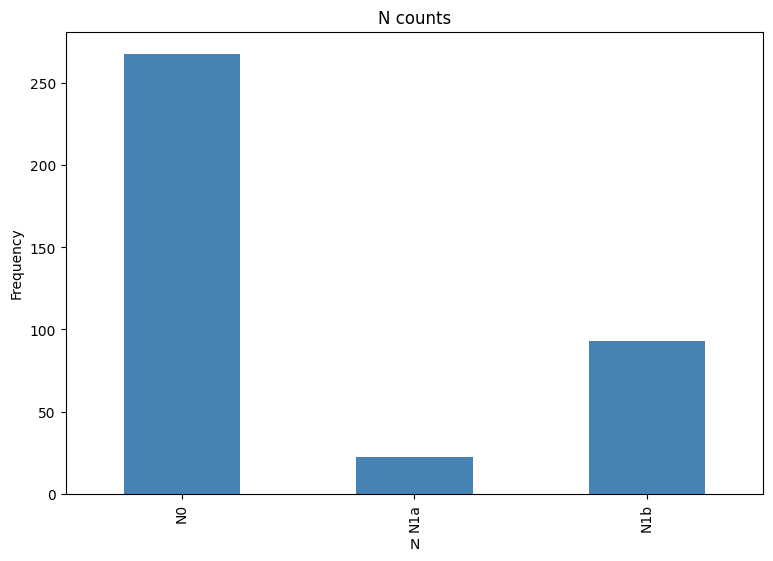

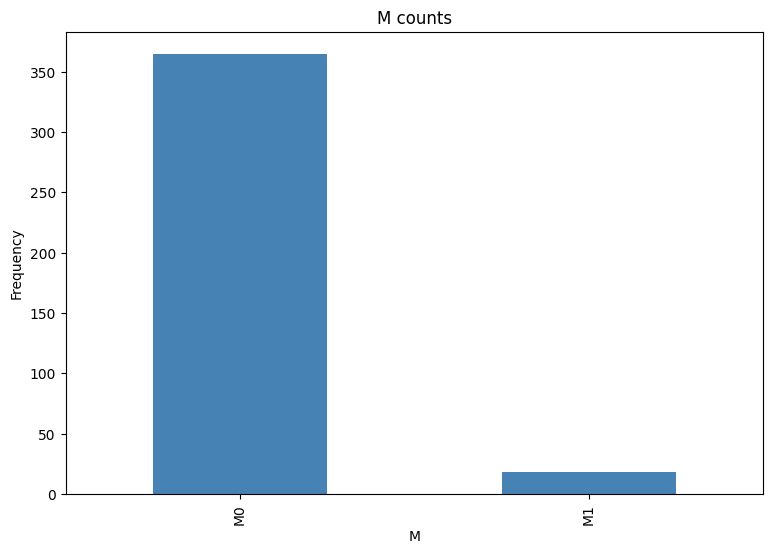

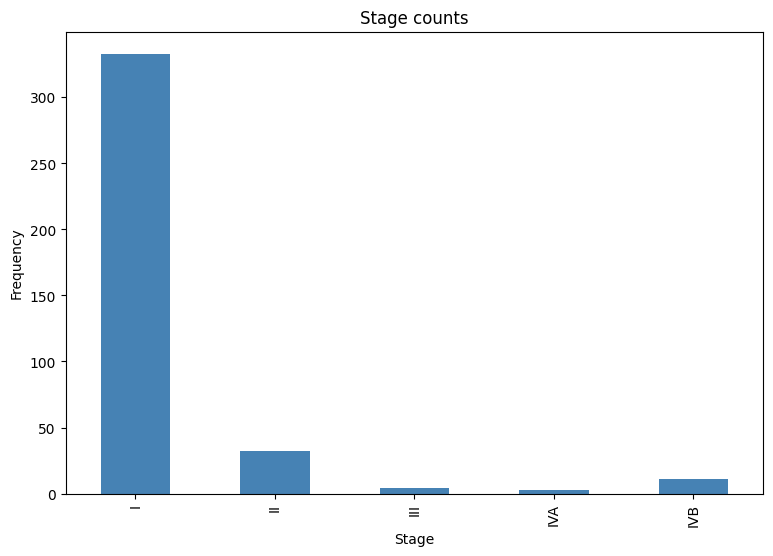

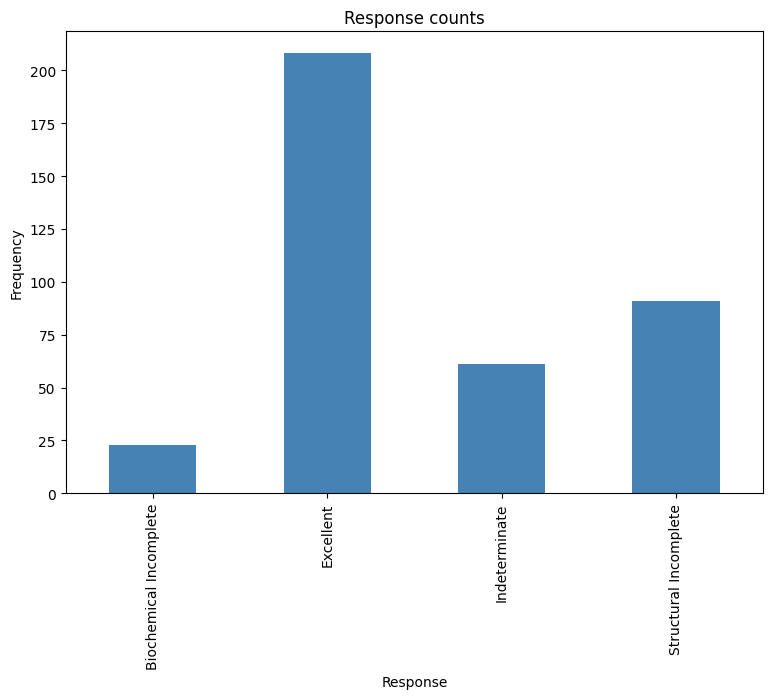

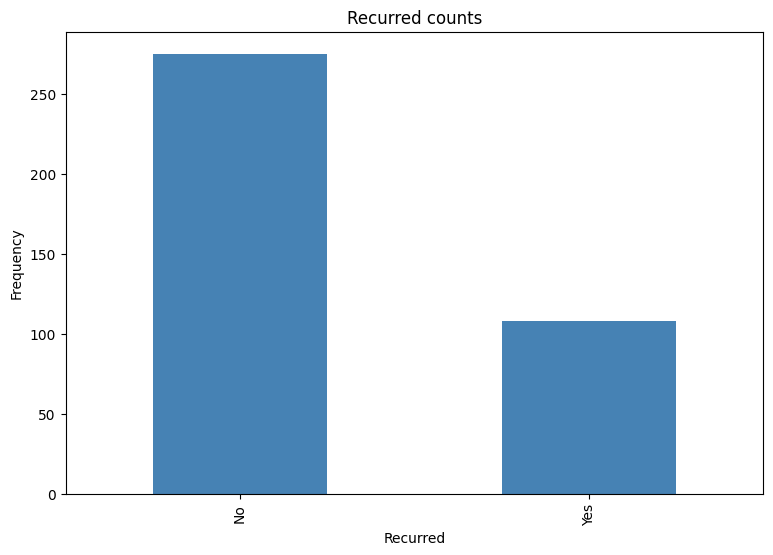

In [ ]:
# plot a bar for each categorical feature count
for col in categorical_cols:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
plt.show()

### Relationships: Numerical & Recurred

In [ ]:
# Set error alpha 0.05
alpha = 0.05
resultAnova = []

# Iterate categorical features
for num in numerical_cols:

    CategoryGroupList = df.groupby('Recurred')[num].apply(list)

    F, pv = f_oneway(*CategoryGroupList)

#     check hypotesis using p value
    if pv < alpha:
        resultAnova.append([num, 'Correlated', pv, 'num'])
    else:
        resultAnova.append([num, 'No Correlated', pv, 'num'])

resultAnova = pd.DataFrame(resultAnova, columns=['Feature', 'Dependency', 'P-value', 'Dtype'])

In [ ]:
# review the strongest correlations
# Other columns will be ignored for training
resultAnova = resultAnova[resultAnova['Dependency'] == 'Correlated']
resultAnova

,Feature,Dependency,P-value,Dtype
0,Age,Correlated,2.776541e-07,num


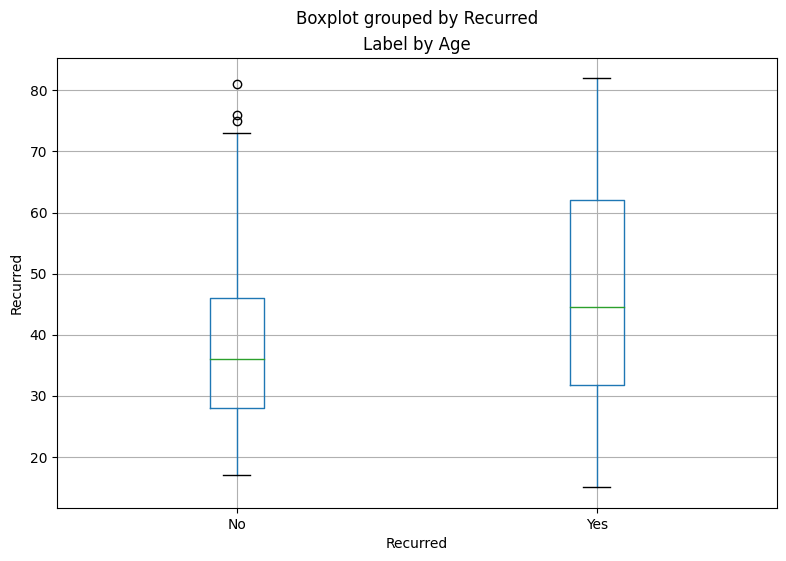

In [ ]:
# Plot data to visualize the key influencers columns
for col in resultAnova['Feature']:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(column=col,by='Recurred',ax=ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("Recurred")
plt.show()

***We can conclude from above that older people tend to suffer from thyroid cancer again***

### Relationships: Categorical & Recurred

In [ ]:
# To make select the best features, we use Chi-square test.
# Null Hypothesis (H0): Two variables are independent
# Alternate Hypothesis (H1): Two variables are not independent

# Create the contingency table

resultChi2 = []
# remove target coll
categorical_cols.remove('Recurred')

for cat in categorical_cols:
    table = df[[cat,'Recurred']]
    table = pd.crosstab(table[cat], table['Recurred'])

    stat, p, dof, expected = chi2_contingency(table)

#     interpret test-statistic
    prob = 0.95

#     get critical chi-square
    critical = chi2.ppf(prob, dof)

    if abs(stat) >= critical:
        resultChi2.append([cat, 'Correlated', critical, 'cat'])
    else:
        resultChi2.append([cat, 'No Correlated', critical, 'cat'])

resultChi2 = pd.DataFrame(resultChi2, columns=['Feature', 'Dependency', 'Critical value', 'Dtype'])

resultChi2 = resultChi2.sort_values(by='Critical value', ascending=True)

In [ ]:
# review the strongest correlations
# Other columns will be ignored for training
resultChi2 = resultChi2[resultChi2['Dependency'] == 'Correlated']
resultChi2

,Feature,Dependency,Critical value,Dtype
0,Gender,Correlated,3.841459,cat
1,Smoking,Correlated,3.841459,cat
2,Hx Smoking,Correlated,3.841459,cat
3,Hx Radiothreapy,Correlated,3.841459,cat
8,Focality,Correlated,3.841459,cat
12,M,Correlated,3.841459,cat
9,Risk,Correlated,5.991465,cat
11,N,Correlated,5.991465,cat
7,Pathology,Correlated,7.814728,cat
14,Response,Correlated,7.814728,cat


# Train the Regression Model

We will use the Logistic Regression model.

We will use LogisticRegression from sklearn. Steps on this section:

* Split Training and Validation Data
* Create Data Preprocess Pipeline
* Train the Model

### Split Training and Validation Data

In [ ]:
final_cols = list(resultAnova['Feature']) + list(resultChi2['Feature'])
final_cols

['Age',
 'Gender',
 'Smoking',
 'Hx Smoking',
 'Hx Radiothreapy',
 'Focality',
 'M',
 'Risk',
 'N',
 'Pathology',
 'Response',
 'Physical Examination',
 'Stage',
 'Adenopathy',
 'T']

In [ ]:
# Split training and validation data
# Separate target from predictions
X = df[final_cols]
y = df['Recurred']

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 56 to 172
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   306 non-null    int64 
 1   Gender                306 non-null    object
 2   Smoking               306 non-null    object
 3   Hx Smoking            306 non-null    object
 4   Hx Radiothreapy       306 non-null    object
 5   Focality              306 non-null    object
 6   M                     306 non-null    object
 7   Risk                  306 non-null    object
 8   N                     306 non-null    object
 9   Pathology             306 non-null    object
 10  Response              306 non-null    object
 11  Physical Examination  306 non-null    object
 12  Stage                 306 non-null    object
 13  Adenopathy            306 non-null    object
 14  T                     306 non-null    object
dtypes: int64(1), object(14)
memory usage: 3

In [ ]:
# Get numerical data and categorical columms from splitted data

numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['object']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

### Create Data Preprocess Pipeline

In [ ]:
# Define preprocessing

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['Age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Smoking', 'Hx Smoking',
                                  'Hx Radiothreapy', 'Focality', 'M', 'Risk',
                                  'N', 'Pathology', 'Response',
                                  'Physical Examination', 'Stage', 'Adenopathy',
                                  'T'])])

### Train the Model

In [ ]:
# define the model

model = LogisticRegression()
model

LogisticRegression()

In [ ]:
# Bundle preprocessor and model
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Preprocessing the training data, fit model
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Smoking',
                                                   'Hx Smoking',
                                                   'Hx Radiothreapy',
                                                   'Focality', 'M', 'Risk', 'N',
                                                   'Pathology', 'Response',
                                                   'Physical Examination',
                                                   'Stage', 'Adenopathy',
                                                   'T'])])),
                ('model', LogisticRegression())])

### Evaluate the Model

In [ ]:
# Make predictions using X_valid dataset

preds = my_pipeline.predict(X_valid)
preds

array(['No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes',
       'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes',
       'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No',
       'Yes', 'Yes', 'No'], dtype=object)

In [ ]:
# create the confusion matrix
# True Negative  | False Positive
# False Negative | True Positive
cm = confusion_matrix(y_valid, preds)
print(cm)

[[49  2]
 [ 4 22]]


In [ ]:
print('Accuracy: ', accuracy_score(y_valid, preds))

Accuracy:  0.922077922077922


# Next Steps

* Fine Tunning Hyperparameters
* Add more evaluation metrics
* Try other models
* Save & Deploy Model